In [96]:
import numpy as np
from collections import Counter

def manhattan(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2)

def step(cx, cy, tx, ty, lrx, lry):
    dc = manhattan(cx, cy, tx, ty)
    dl = manhattan(lrx, lry, tx, ty)
    if dl < dc-1:
        return lrx, lry
    if cx < tx:
        cx += 1
    elif cx > tx:
        cx -= 1
    else:
        if cy < ty:
            cy += 1
        elif cy > ty:
            cy -= 1
    return cx, cy


N = 501
#reference = sample_lr(0, 0, N, ALPHA)

precomputed = np.zeros((N*2, N*2))
for i in range(N*2):
    for j in range(N*2):
        precomputed[i, j] = manhattan(i,j, N, N)

def fast_distance_mtx(cx, cy):
    xstart = N - cx
    ystart = N - cy
    return precomputed[xstart:xstart+N, ystart:ystart+N]

def fast_proba_mtx(cx, cy):
    xstart = N - cx
    ystart = N - cy
    return precomputed_proba[xstart:xstart+N, ystart:ystart+N]


indices = np.arange(N**2)


def sample_lr(cx, cy, n, alpha):
    proba_matrix = fast_proba_mtx(cx, cy)
    probas = proba_matrix.flatten()
    probas[np.isnan(probas)] = 0
    probas /= np.sum(probas)
    choice = np.random.choice(indices, p=probas)
    tx, ty = choice // n, choice % n
    return tx, ty


#ALPHA = 1.0

distances = {}
from tqdm import tqdm
for alpha in np.linspace(0, 2.5, 26):
    precomputed_proba = np.zeros((N*2, N*2))
    for i in range(N*2):
        for j in range(N*2):
            d = precomputed[i, j]
            if d <= 1:
                continue
            precomputed_proba[i, j] = d ** -alpha

    distances[alpha] = []

    for _ in tqdm(range(200), total=200):
        cx, cy = (np.random.randint(0, N), np.random.randint(0, N))
        tx, ty = (np.random.randint(0, N), np.random.randint(0, N))
        steps = 0
        while not (cx == tx and cy == ty):
            steps += 1
            cx, cy = step(cx, cy, tx, ty, *sample_lr(cx, cy, N, alpha))
        
        distances[alpha].append(steps)

100%|██████████| 200/200 [00:28<00:00,  7.14it/s]


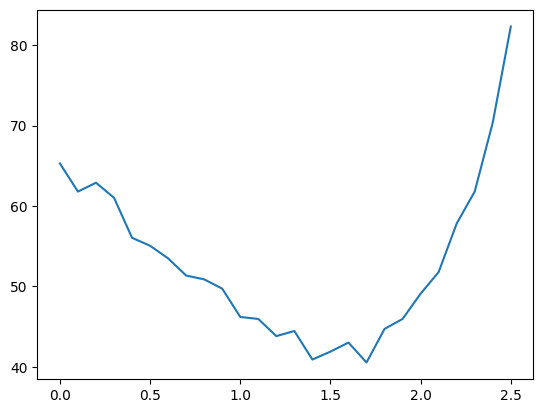

In [97]:
import matplotlib.pyplot as plt

plt.plot(distances.keys(), [np.mean(distances[alpha]) for alpha in distances.keys()])

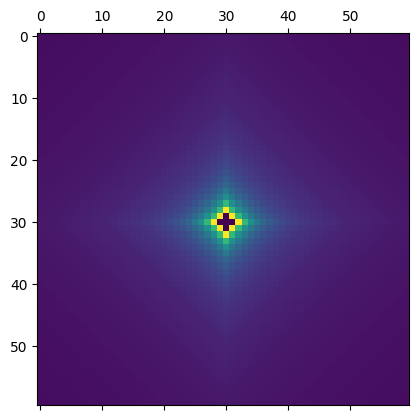

In [103]:
N = 30
alpha = 1

precomputed = np.zeros((N*2, N*2))
for i in range(N*2):
    for j in range(N*2):
        precomputed[i, j] = manhattan(i,j, N, N)

precomputed_proba = np.zeros((N*2, N*2))
for i in range(N*2):
    for j in range(N*2):
        d = precomputed[i, j]
        if d <= 1:
            continue
        precomputed_proba[i, j] = d ** -alpha


plt.matshow(precomputed_proba)

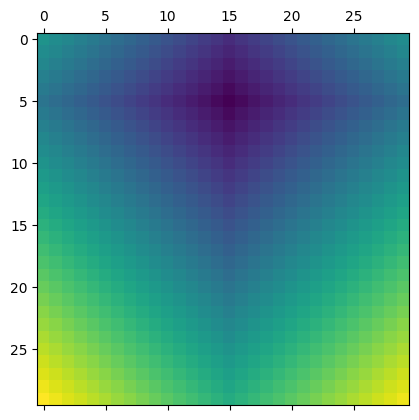

In [112]:
_mtx = fast_distance_mtx(5,15)
plt.matshow(_mtx)
cnt = Counter(_mtx.flatten().astype(int).tolist())

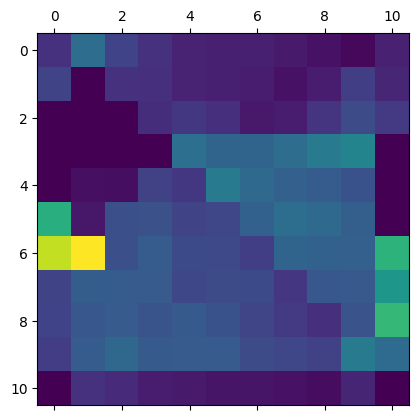

In [290]:
def partial_cnt(w, h):
    return {i: i - max(0,i-h) - max(0, i-w) for i in range(1, w + h)}

def full_cnt(n, x, y):
    upright = partial_cnt(n-x, n-y-1)
    upleft = partial_cnt(n-y, x)
    downright = partial_cnt(y+1, n-x-1)
    downleft = partial_cnt(x+1, y)
    combined = Counter()
    for cnt in [upright, upleft, downright, downleft]:
        combined.update(cnt)
    return dict(combined), (upright, upleft, downright, downleft)


def sample_distance(n, x, y, alpha):
    distance_counts, separate = full_cnt(n, x, y)
    max_distance = max(distance_counts.keys())
    values = np.arange(2, max_distance+1)
    probas = np.array([distance_counts[v] * float(v) ** -alpha for v in values])
    probas /= np.sum(probas)
    choice = np.random.choice(values, p=probas)
    return choice, distance_counts, separate


directions = ["upright", "upleft", "downright", "downleft"]
def sample_lrng(n, x, y, alpha):
    distance, combined, separate = sample_distance(n, x, y, alpha)
    index = np.random.randint(0, combined[distance])
    
    selected_dir = None
    for direction, cnt in zip(directions, separate):
        if index < cnt[distance]:
            selected_dir = direction
            break
        index -= cnt[distance]
    
    if selected_dir == "upright":
        w_box, h_box = n-x, n-y-1
    elif selected_dir == "upleft":
        w_box, h_box = n-y, x
    elif selected_dir == "downright":
        w_box, h_box = y+1, n-x-1
    elif selected_dir == "downleft":
        w_box, h_box = x+1, y

    
    # randomize x,y such that their sum is equal to distance
    min_x = max(distance - w_box, 0)
    if min_x >= w_box:
        dx = w_box
    else:
        dx = np.random.randint(min_x, w_box)
    dy = distance - dx

    if selected_dir == "upright":
        off_x = dx + x
        off_y = dy + y + 1
    elif selected_dir == "upleft":
        off_x = x - dy - 1
        off_y = y + dx
    elif selected_dir == "downright":
        off_x = x + dy + 1
        off_y = y - dx
    elif selected_dir == "downleft":
        off_x = x - dx 
        off_y = y - dy - 1
    return off_x, off_y

    

N = 10
q = np.zeros((N+1,N+1))
for _ in range(10000):
    x, y = sample_lrng(N, 3, 1, 1)
    q[x,y] += 1
plt.matshow(q)
plt.show()